# Experiment 2: Content
## How sensitive is the T5-ASP model to changes in gazetteer content quality and quantity?

### Datasets

In [2]:
thesis_path = "/Users/robinloebbert/Masterarbeit/thesis"

In [3]:
import json
import os

with open(os.path.join(thesis_path, "data/mlowner/lowner_train.json"),
          encoding="utf-8") as file:
    lowner_train = json.load(file)

with open(os.path.join(thesis_path, "data/mlowner/lowner_dev.json"),
          encoding="utf-8") as file:
    lowner_dev = json.load(file)

with open(os.path.join(thesis_path, "data/mlowner/lowner_test.json"),
          encoding="utf-8") as file:
    lowner_test = json.load(file)

with open(os.path.join(thesis_path, "data/mlowner/lowner_gazetteer.json"),
          encoding="utf-8") as file:
    lowner_gazetteer = json.load(file)

with open(
        os.path.join(thesis_path, "data/multiconer/multiconer_test.json"),
        encoding="utf-8") as file:
    multiconer_test = json.load(file)

with open(os.path.join(thesis_path, "data/mlowner/lowner_types.json"), encoding="utf-8") as file:
    types = json.load(file)["entities"]


### Scenario
Painstakingly labeled amount of data:
- 100% Lowner train + dev dataset
- 12000 items of multiconer-test (2000 each): uniform distribution of labels
- parts of lowner gazetteer: top-5 similarity sampled by using parts of multiconer-test -> quick gazetteers

#### Multiconer + gazetteer data sampling

In [4]:
from typing import List
from collections import defaultdict, Counter
import random
import pandas as pd

def per_type_uniform_sampling(dataset: List[dict], types: List[str], sample_size: int):
    # count entities per doc
    doc_entity_count = []
    for doc in dataset:
        doc_entity_count.append({
            "doc_id": doc["doc_id"],
            **Counter([ent["type"] for ent in doc["entities"]])
        })
    count_df = pd.DataFrame.from_records(doc_entity_count).fillna(0)

    # get types
    type_to_ids = {
        t: frozenset(count_df[count_df[t]>0]["doc_id"].tolist())
        for t in types
    }
    type_count = defaultdict(int)
    sampled_ids = set()

    type_set = list(types)
    random.shuffle(type_set)

    for typ in type_set:
        done_sampling = False
        while not done_sampling:
            if type_count[typ] >= sample_size:
                done_sampling = True
                break
            sample_set = list(type_to_ids[typ].difference(sampled_ids))
            select_id = random.choice(sample_set)
            sampled_ids.add(select_id)
            entity_count = count_df[count_df["doc_id"]==select_id].iloc[0]
            for t in types:
                type_count[t]+=entity_count[t]

    return [doc for doc in dataset if doc["doc_id"] in sampled_ids], type_count


In [5]:
import random
random.seed(1)
docs1, type_count1 = per_type_uniform_sampling(
    multiconer_test, types, 2000)


In [ ]:

random.seed(2)
docs2, type_count2 = per_type_uniform_sampling(
    multiconer_test, types, 2000)

random.seed(3)
docs3, type_count3 = per_type_uniform_sampling(multiconer_test, types, 2000)


In [4]:
type_count1, type_count2, type_count3

(defaultdict(int,
             {'corporation': 2256.0,
              'location': 2104.0,
              'group': 2001.0,
              'person': 2556.0,
              'creative-work': 2047.0,
              'product': 2056.0}),
 defaultdict(int,
             {'corporation': 2277.0,
              'location': 2000.0,
              'group': 2132.0,
              'person': 2584.0,
              'creative-work': 2075.0,
              'product': 2017.0}),
 defaultdict(int,
             {'location': 2297.0,
              'group': 2000.0,
              'corporation': 2205.0,
              'person': 2504.0,
              'creative-work': 2048.0,
              'product': 2033.0}))

In [5]:
docs1_set = set([doc["doc_id"] for doc in docs1])
docs2_set = set([doc["doc_id"] for doc in docs2])
docs3_set = set([doc["doc_id"] for doc in docs3])

docs1_docs2_overlap = docs1_set.intersection(docs2_set)
docs1_docs3_overlap = docs1_set.intersection(docs3_set)
docs2_docs3_overlap = docs2_set.intersection(docs3_set)

res = {
    "docs1_to_docs2": len(docs1_docs2_overlap) / len(docs1_set),
    "docs2_to_docs1": len(docs1_docs2_overlap) / len(docs2_set),
    "docs1_to_docs3": len(docs1_docs3_overlap) / len(docs1_set),
    "docs3_to_docs1": len(docs1_docs3_overlap) / len(docs3_set),
    "docs2_to_docs3": len(docs2_docs3_overlap) / len(docs2_set),
    "docs3_to_docs2": len(docs2_docs3_overlap) / len(docs3_set),
}
res, len(docs1_set), len(docs2_set), len(docs3_set)

({'docs1_to_docs2': 0.05031511519785102,
  'docs2_to_docs1': 0.05076089222430686,
  'docs1_to_docs3': 0.05114164686434549,
  'docs3_to_docs1': 0.0509416486569929,
  'docs2_to_docs3': 0.04857202418178028,
  'docs3_to_docs2': 0.04795718843264382},
 9679,
 9594,
 9717)

Expected Entity Coverage Ratio: 100%|██████████| 49/49 [00:00<00:00, 452689.20it/s]


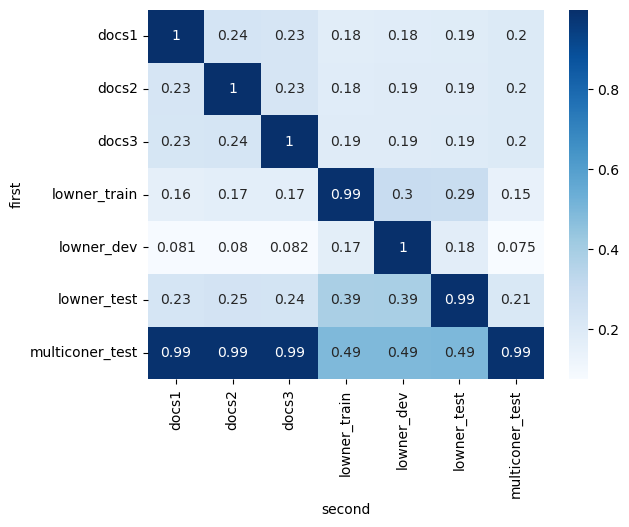

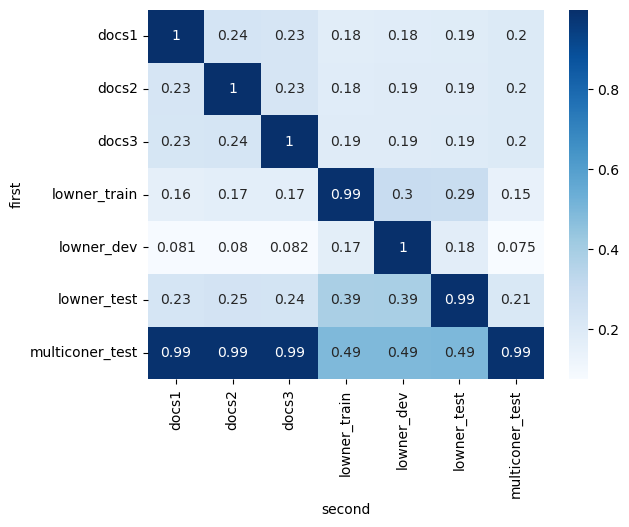

In [8]:
from data_metrics.entity_coverage_ratio import confusion_matrix_expected_entity_coverage_ratio
from data_metrics.utils import visualize_confusion_matrix

cm = confusion_matrix_expected_entity_coverage_ratio([
    lowner_train, lowner_dev, lowner_test, docs1, docs2, docs3, multiconer_test
], [
    "lowner_train", "lowner_dev", "lowner_test", "docs1", "docs2", "docs3",
    "multiconer_test"
])
visualize_confusion_matrix(cm, "expected_entity_coverage_ratio")

### Scenario
Unfortunately, you made labelling mistakes and the data contains spelling errors as well
- Was not that bad, but you noticed it (possible scenarios: 5%, 10%, 15% - https://arxiv.org/abs/2103.14749)
- Data augmentation to introduce labelling errors: based on error types
    - Wrong span, correct label: if len == 1, increase left or right, else increase/decrease left or right (depending on sentence length)
    - Wrong span, wrong label: if len == 1, increase left or right, else increase/decrease left or right (depending on sentence length) and randomize label
    - wrong labels, correct span: randomize label
    - not labeled (false negative): remove label
    - false positive: Take unlabeled noun phrases and randomly choose a label
- Data augmentation to introduce spelling/typing errors: https://github.com/makcedward/nlpaug

#### Application
- make 5%, 10% or 15% of the whole dataset erroneous
- pick a random suite of augmentations, shuffle their application order and apply them on the example

#### Metrics
In order to measure the augmentation effect, use the Error Metrics (entities) und do an exact text match

In [6]:
len(docs1), type_count1

(9704,
 defaultdict(int,
             {'corporation': 2264.0,
              'location': 2104.0,
              'group': 2000.0,
              'person': 2534.0,
              'creative-work': 2066.0,
              'product': 2057.0}))

#### Error Type 1 - False positives

In [230]:
from flair.models import SequenceTagger
from flair.data import Sentence
from typing import List
import random
import numpy as np
import copy

example1 = {"tokens": ["walsh", "first", "came", "to", "prominence", "at", "inter", "county", "level", "as", "a", "member", "of", "the", "waterford", "minor", "hurling", "team", ",", "however", ",", "he", "had", "little", "success", "in", "this", "grade", "."], "extended": ["walsh", "first", "came", "to", "prominence", "at", "inter", "county", "level", "as", "a", "member", "of", "the", "waterford", "minor", "hurling", "team", ",", "however", ",", "he", "had", "little", "success", "in", "this", "grade", "."], "entities": [{"type": "group", "start": 14, "end": 15}], "doc_id": "lowner_train_1"}
example2 = {"tokens": ["william", "t.", "glidden", ",", "clipper", "ship", "line", "co", "owner", "and", "railroad", "investor"], "extended": ["william", "t.", "glidden", ",", "clipper", "ship", "line", "co", "owner", "and", "railroad", "investor"], "entities": [{"type": "person", "start": 0, "end": 3}], "doc_id": "lowner_train_0"}
tagger = SequenceTagger.load("flair/pos-english-fast")

def get_random_mask(size: int):
    if size == 0:
        return []
    mask = np.random.randint(2, size=size)
    if mask.sum() == 0:
        mask[np.random.randint(size)] = 1
    return mask.tolist()

def error_type1_augmentation(sample: dict, types: List[str]):
    augmented_sample = copy.deepcopy(sample)
    entity_spans = {(ent["start"], ent["end"]) for ent in augmented_sample["entities"]}
    # false positive: Take unlabeled noun phrases and randomly choose a label
    sent = Sentence(augmented_sample["tokens"])
    tagger.predict(sent)
    phrases = set()
    current_phrase = {"start": -1, "end": -1}
    for token in sent.get_labels("pos"):
        if "NN" in token.value:
            if current_phrase["start"] == -1:
                current_phrase["start"] = token.data_point.idx - 1
            current_phrase["end"] = token.data_point.idx
        elif current_phrase["end"]>-1:
            phrases.add((current_phrase["start"], current_phrase["end"]))
            current_phrase = {"start": -1, "end": -1}
    if current_phrase["end"]>-1:
        phrases.add((current_phrase["start"], current_phrase["end"]))

    valid_spans = list(phrases.difference(entity_spans))
    mask = get_random_mask(len(valid_spans))
    for span, valid in zip(valid_spans, mask): # type: ignore
        if valid:
            augmented_sample["entities"].append({
                "start": span[0],
                "end": span[1],
                "type": random.choice(types)
            })
    
    return augmented_sample



2023-06-03 10:36:05,442 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [231]:

res = error_type1_augmentation(example1, list(types))
res

{'tokens': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'extended': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'entities': [{'type': 'group', 'start': 14, 'end': 15},
  {'start': 0, 'end': 1, 'type': 'group'},
  {'start': 4, 'end': 5, 'type': 'creative-work'},
  {'start': 24, 'end': 25, 'type': 'product'},
  {'start': 16, 'end': 18, 'type': 'group'},
  {'start': 27, 'end': 28, 'type': 'product'}],
 'doc_id': 'lowner_train_1'}

#### Error Type 2 - False negatives

In [234]:
import numpy as np
import copy

def error_type2_augmentation(sample: dict, types: List[str]):
    augmented_sample = copy.deepcopy(sample)
    # not labeled (false negative): remove label
    mask = get_random_mask(len(augmented_sample["entities"]))
    augmented_sample["entities"] = [ent for valid, ent in zip(mask, augmented_sample["entities"]) if not valid]
    return augmented_sample

res = error_type2_augmentation(example1, list(types))
res

{'tokens': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'extended': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'entities': [],
 'doc_id': 'lowner_train_1'}

#### Error type 3 - wrong labels, correct span
randomize label

In [235]:
import copy
def error_type3_augmentation(sample: dict, types: List[str]):
    # wrong labels, correct span: randomize label
    augmented_sample = copy.deepcopy(sample)
    mask = get_random_mask(len(augmented_sample["entities"]))
    type_set = set(types)
    for valid, entity in zip(mask, augmented_sample["entities"]):
        if valid:
            valid_types = list(type_set.difference([entity["type"]]))
            entity["type"] = random.choice(valid_types)
    return augmented_sample

res = error_type3_augmentation(example1, list(types))
res

{'tokens': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'extended': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'entities': [{'type': 'corporation', 'start': 14, 'end': 15}],
 'doc_id': 'lowner_train_1'}

#### Error Type 4 - Overlapping span, wrong label
Wrong span, wrong label: if len == 1, increase left or right, else increase/decrease left or right (depending on sentence length) and randomize label

In [237]:
import copy

def error_type4_augmentation(sample: dict,
                             types: List[str], avg_entity_length: int = 3):
    augmented_sample = copy.deepcopy(sample)
    max_end = len(augmented_sample["tokens"])
    min_start = 0
    mask = get_random_mask(len(augmented_sample["entities"]))
    augmented_sample["entities"] = sorted(augmented_sample["entities"], key=lambda x: x["start"])
    type_set = set(types)
    action = {"increase", "decrease"}
    direction = {"left", "right", "both"}

    def apply_left_action(ents: List[dict], ent_idx: int, ent: dict, action: str):
        if action == "increase":
            # get left border
            left_space = 0
            if ent_idx > 0:
                left_space = ent["start"] - ents[ent_idx-1]["end"]
            else:
                left_space = ent["start"]
            left_space = left_space if left_space <= avg_entity_length else avg_entity_length
            ent["start"] -= random.randint(1, left_space) if left_space > 0 else 0
        elif action == "decrease":
            # get entity end as right border
            right_space = ent["end"] - ent["start"] - 1
            ent["start"] += random.randint(1, right_space) if right_space > 0 else 0

    def apply_right_action(ents: List[dict], ent_idx: int, ent: dict, action: str):
        if action == "increase":
            # get right border
            right_space = 0
            if ent_idx < len(ents) - 1:
                right_space = ents[ent_idx+1]["start"] - ent["end"]
            else:
                right_space = max_end - ent["end"]
            right_space = right_space if right_space <= avg_entity_length else avg_entity_length
            ent["end"] += random.randint(1, right_space) if right_space > 0 else 0
        elif action == "decrease":
            # get entity start as right border
            left_space = ent["end"] - ent["start"] - 1
            ent["end"] -= random.randint(1, left_space) if left_space > 0 else 0
        
    for valid, entity_idx, entity in zip(mask, range(len(augmented_sample["entities"])), # type: ignore
                                         augmented_sample["entities"]):  
        if valid:
            entity_length = entity["end"] - entity["start"]
            valid_actions = copy.deepcopy(action)
            valid_directions = copy.deepcopy(direction)
            if entity_length == 1:
                # increase only
                valid_actions.remove("decrease")
            if (entity_idx > 0 and augmented_sample["entities"][entity_idx - 1]["end"]
                    == entity["start"] - 1) or entity["start"] == min_start:
                # right only
                valid_directions.remove("left")
                valid_directions.remove("both")
            if (entity_idx < len(augmented_sample["entities"]) - 1 and augmented_sample["entities"][entity_idx + 1]["start"]
                    == entity["end"] + 1) or entity["end"] == max_end:
                # left only
                valid_directions.remove("right")
                if "both" in valid_directions:
                    valid_directions.remove("both")

            if len(valid_actions) > 0 and len(valid_directions) > 0:
                direction_chosen = random.choice(list(valid_directions))
                if direction_chosen == "both":
                    apply_left_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
                    apply_right_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
                elif direction_chosen == "left":
                    apply_left_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
                elif direction_chosen == "right":
                    apply_right_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))

            # randomize label
            valid_types = list(type_set.difference([entity["type"]]))
            entity["type"] = random.choice(valid_types)
            
    return augmented_sample

res = error_type4_augmentation(example1, list(types))
res

{'tokens': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'extended': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'entities': [{'type': 'product', 'start': 14, 'end': 18}],
 'doc_id': 'lowner_train_1'}

#### Error Type 5 - Overlapping span, correct label
if len == 1, increase left or right, else increase/decrease left or right (depending on sentence length)

In [240]:
import copy
def error_type5_augmentation(sample: dict,
                             types: List[str], avg_entity_length: int = 3):
    augmented_sample = copy.deepcopy(sample)
    # Overlapping span, correct label: if len == 1, increase left or right, else increase/decrease left or right (depending on sentence length)
    max_end = len(augmented_sample["tokens"])
    min_start = 0
    mask = get_random_mask(len(augmented_sample["entities"]))
    augmented_sample["entities"] = sorted(augmented_sample["entities"], key=lambda x: x["start"])
    action = {"increase", "decrease"}
    direction = {"left", "right", "both"}

    def apply_left_action(ents: List[dict], ent_idx: int, ent: dict, action: str):
        if action == "increase":
            # get left border
            left_space = 0
            if ent_idx > 0:
                left_space = ent["start"] - ents[ent_idx-1]["end"]
            else:
                left_space = ent["start"]
            left_space = left_space if left_space <= avg_entity_length else avg_entity_length
            ent["start"] -= random.randint(1, left_space) if left_space > 0 else 0
        elif action == "decrease":
            # get entity end as right border
            right_space = ent["end"] - ent["start"] - 1
            ent["start"] += random.randint(1, right_space) if right_space > 0 else 0

    def apply_right_action(ents: List[dict], ent_idx: int, ent: dict, action: str):
        if action == "increase":
            # get right border
            right_space = 0
            if ent_idx < len(ents) - 1:
                right_space = ents[ent_idx+1]["start"] - ent["end"]
            else:
                right_space = max_end - ent["end"]
            right_space = right_space if right_space <= avg_entity_length else avg_entity_length
            ent["end"] += random.randint(1, right_space) if right_space > 0 else 0
        elif action == "decrease":
            # get entity start as right border
            left_space = ent["end"] - ent["start"] - 1
            ent["end"] -= random.randint(1, left_space) if left_space > 0 else 0
        
    for valid, entity_idx, entity in zip(mask, range(len(augmented_sample["entities"])), # type: ignore
                                         augmented_sample["entities"]):  
        if valid:
            entity_length = entity["end"] - entity["start"]
            valid_actions = copy.deepcopy(action)
            valid_directions = copy.deepcopy(direction)
            if entity_length == 1:
                # increase only
                valid_actions.remove("decrease")
            if (entity_idx > 0 and augmented_sample["entities"][entity_idx - 1]["end"]
                    == entity["start"] - 1) or entity["start"] == min_start:
                # right only
                valid_directions.remove("left")
                valid_directions.remove("both")
            if (entity_idx < len(augmented_sample["entities"]) - 1 and augmented_sample["entities"][entity_idx + 1]["start"]
                    == entity["end"] + 1) or entity["end"] == max_end:
                # left only
                valid_directions.remove("right")
                if "both" in valid_directions:
                    valid_directions.remove("both")

            if len(valid_actions) > 0 and len(valid_directions) > 0:
                direction_chosen = random.choice(list(valid_directions))
                if direction_chosen == "both":
                    apply_left_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
                    apply_right_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
                elif direction_chosen == "left":
                    apply_left_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
                elif direction_chosen == "right":
                    apply_right_action(augmented_sample["entities"], entity_idx, entity, random.choice(list(valid_actions)))
    return augmented_sample
                    
   
res = error_type5_augmentation(example1, list(types))
res
            

{'tokens': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'extended': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'entities': [{'type': 'group', 'start': 12, 'end': 15}],
 'doc_id': 'lowner_train_1'}

### Keyboard errors

In [242]:
from nlpaug.augmenter.char import KeyboardAug


keyboard_aug = KeyboardAug(aug_char_p=0.2,
                           aug_char_max=3,
                           aug_word_p=0.05,
                           aug_word_max=6,
                           tokenizer=lambda x: x.split(" "),
                           reverse_tokenizer=lambda x: " ".join(x),
                           include_numeric=False,
                           include_special_char=False,
                           include_upper_case=False)

def spelling_error_augmentation(sample: dict, types: List[str]):
    augmented_sample = copy.deepcopy(sample)
    augmented_sample["tokens"] = keyboard_aug.augment(" ".join(augmented_sample["tokens"]))[0].split(" ")
    return augmented_sample
    

res = spelling_error_augmentation(example1, types)
res

{'tokens': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'memnfr',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'teak',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'extended': ['walsh',
  'first',
  'came',
  'to',
  'prominence',
  'at',
  'inter',
  'county',
  'level',
  'as',
  'a',
  'member',
  'of',
  'the',
  'waterford',
  'minor',
  'hurling',
  'team',
  ',',
  'however',
  ',',
  'he',
  'had',
  'little',
  'success',
  'in',
  'this',
  'grade',
  '.'],
 'entities': [{'type': 'group', 'start': 14, 'end': 15}],
 'doc_id': 'lowner_train_1'}

### Application
- make 5%, 10% or 15% of the whole dataset erroneous
- pick a random suite of augmentations, shuffle their application order and apply them on the example

In [243]:
import numpy as np
def make_erroneous_dataset(dataset: List[dict], types: List[str], ratio: float):
    result_dataset = copy.deepcopy(dataset)
    mask = np.zeros(len(dataset))
    error_size = round(len(dataset) * ratio)+1
    mask[:error_size] = 1
    np.random.shuffle(mask)

    type_list = list(types)

    # augmentations
    augmentations = [error_type1_augmentation, error_type2_augmentation, error_type3_augmentation, error_type4_augmentation, error_type5_augmentation, spelling_error_augmentation]
     
    for valid, sample_idx, sample in zip(mask, range(len(dataset)), dataset):
        if valid:
            mask_augmentations = get_random_mask(len(augmentations))
            random.shuffle(augmentations)
            augmented_sample = copy.deepcopy(sample)
            for valid_aug, aug in zip(mask_augmentations, augmentations):
                if valid_aug:
                    augmented_sample = aug(augmented_sample, type_list)
            result_dataset[sample_idx] = augmented_sample
            
    return result_dataset


In [244]:
seed = 1
np.random.seed(seed)
random.seed(seed)
res_dataset1 = make_erroneous_dataset(lowner_train, types, 0.15)
             

In [246]:
seed = 2
np.random.seed(seed)
random.seed(seed)
res_dataset2 = make_erroneous_dataset(lowner_train, types, 0.15)

In [247]:
seed = 3
np.random.seed(seed)
random.seed(seed)
res_dataset3 = make_erroneous_dataset(lowner_train, types, 0.15)

TODO: Fix augmentation output, so that it just works on a sample, because keyboard augmentations
- Add Metrics check

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
	- Avoid using `tokenizers` before the fork if possible
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadloc

Expected Entity Coverage Ratio: 100%|██████████| 16/16 [00:00<00:00, 100462.37it/s]


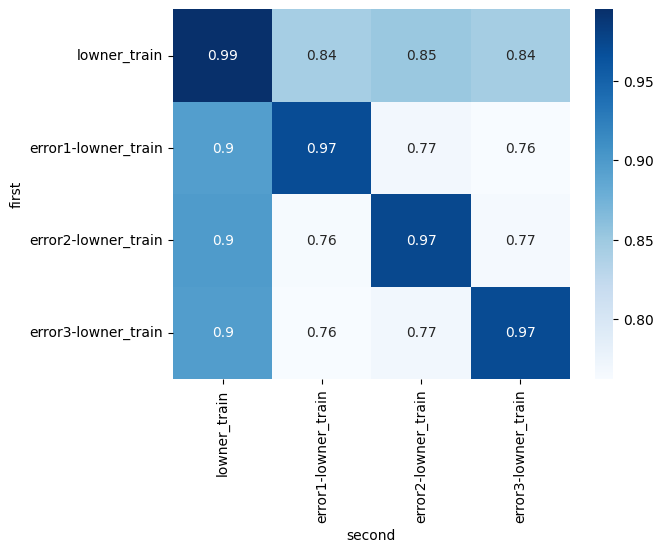

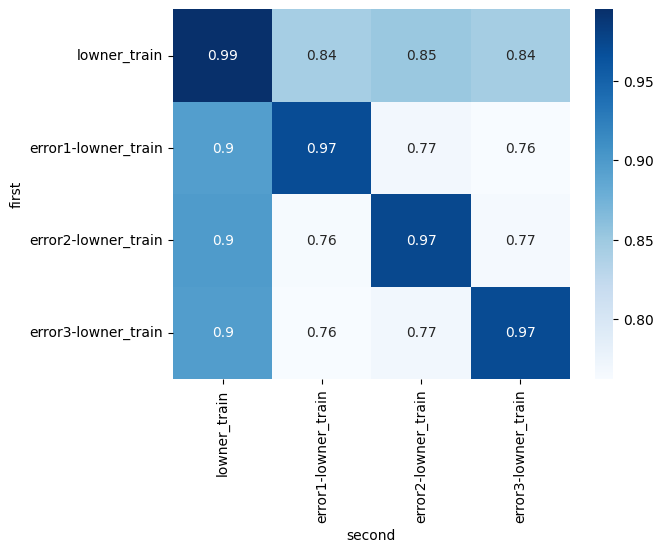

In [248]:
from data_metrics.entity_coverage_ratio import confusion_matrix_expected_entity_coverage_ratio
from data_metrics.utils import visualize_confusion_matrix

cm = confusion_matrix_expected_entity_coverage_ratio([
    lowner_train, res_dataset1, res_dataset2, res_dataset3
], [
    "lowner_train", "error1-lowner_train", "error2-lowner_train", "error3-lowner_train"
])
visualize_confusion_matrix(cm, "expected_entity_coverage_ratio")

In [261]:
from models.metrics import ASPMetrics

def get_augmentation_errors(aug_dataset: List[dict], dataset: List[dict]):
    assert len(aug_dataset) == len(dataset)
    metrics = ASPMetrics()
    spelling_errors = 0
    tokens = 0

    def to_prediction(entities: List[dict]):
        return [(ent["start"], ent["end"], ent["type"]) for ent in entities]

    for aug_sample, sample in zip(aug_dataset, dataset):
        assert aug_sample["doc_id"] == sample["doc_id"]
        metrics.update(sample["doc_id"], to_prediction(aug_sample["entities"]), to_prediction(sample["entities"]))
        for token_idx in range(len(sample["tokens"])):
            if aug_sample["tokens"][token_idx] != sample["tokens"][token_idx]:
                spelling_errors+=1
        tokens+=len(sample["tokens"])

    errors = metrics.errors()
    return {
        "spelling_errors": spelling_errors,
        "error_type1": errors[0],
        "error_type2": errors[1],
        "error_type3": errors[2],
        "error_type4": errors[3],
        "error_type5": errors[4],
    }

get_augmentation_errors(res_dataset1, lowner_train)

{'spelling_errors': 1120,
 'error_type1': 1129,
 'error_type2': 784,
 'error_type3': 472,
 'error_type4': 817,
 'error_type5': 260}

In [288]:
import pandas as pd

errors1 = get_augmentation_errors(res_dataset1, lowner_train)
errors1.update({"seed": 1})
errors2 = get_augmentation_errors(res_dataset2, lowner_train)
errors2.update({"seed": 2})
errors3 = get_augmentation_errors(res_dataset3, lowner_train)
errors3.update({"seed": 3})

error_df = pd.DataFrame.from_records([errors1, errors2, errors3])

seed,1,2,3
error_type1,1129,1065,1165
error_type2,784,819,782
error_type3,472,396,390
error_type4,817,795,821
error_type5,260,262,285
spelling_errors,1120,1159,1164


In [289]:
error_pivot = error_df.pivot_table(columns="seed")

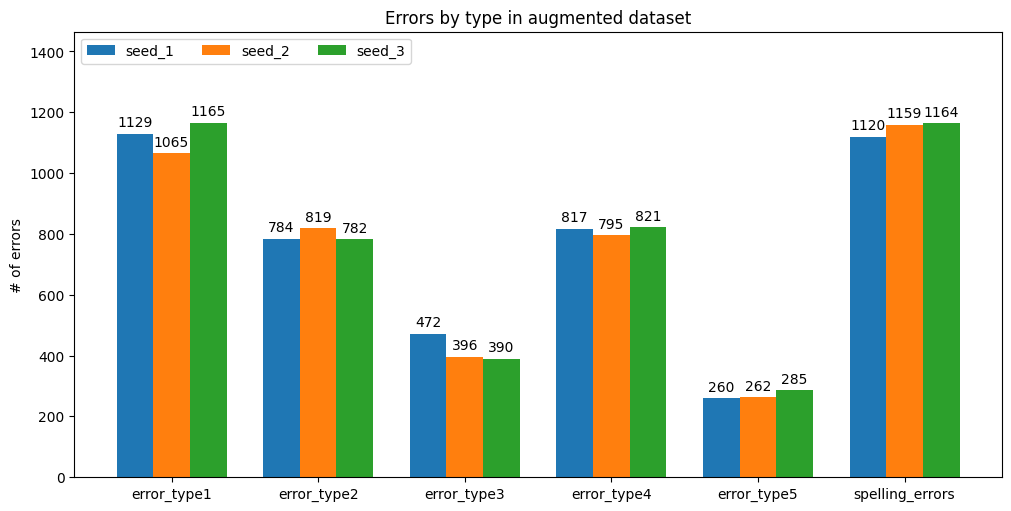

In [295]:
import matplotlib.pyplot as plt
import numpy as np

rows = error_pivot.index.to_list()
categories = error_pivot.columns.to_list()
column_values = {f"seed_{col}": error_pivot[col].to_list()
    for col in categories
}

x = np.arange(len(rows))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

for attribute, measurement in column_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of errors')
ax.set_title('Errors by type in augmented dataset')
ax.set_xticks(x + width, rows)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, max(error_df.max())+300)

plt.show()